In [73]:
from yahtzee import Game
from constants import CATEGORIES
from greedy_strategy import GreedyStrategy
from random_strategy import RandomStrategy
from strategy_utils import score_all_rolls
from itertools import combinations_with_replacement, combinations, product
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.ticker as mtick
import math

import matplotlib.pyplot as plt

## Background: How do the potential scores of various rolls differ?

In [22]:
g = Game()
all_rolls, all_rolls_scores = score_all_rolls(g)

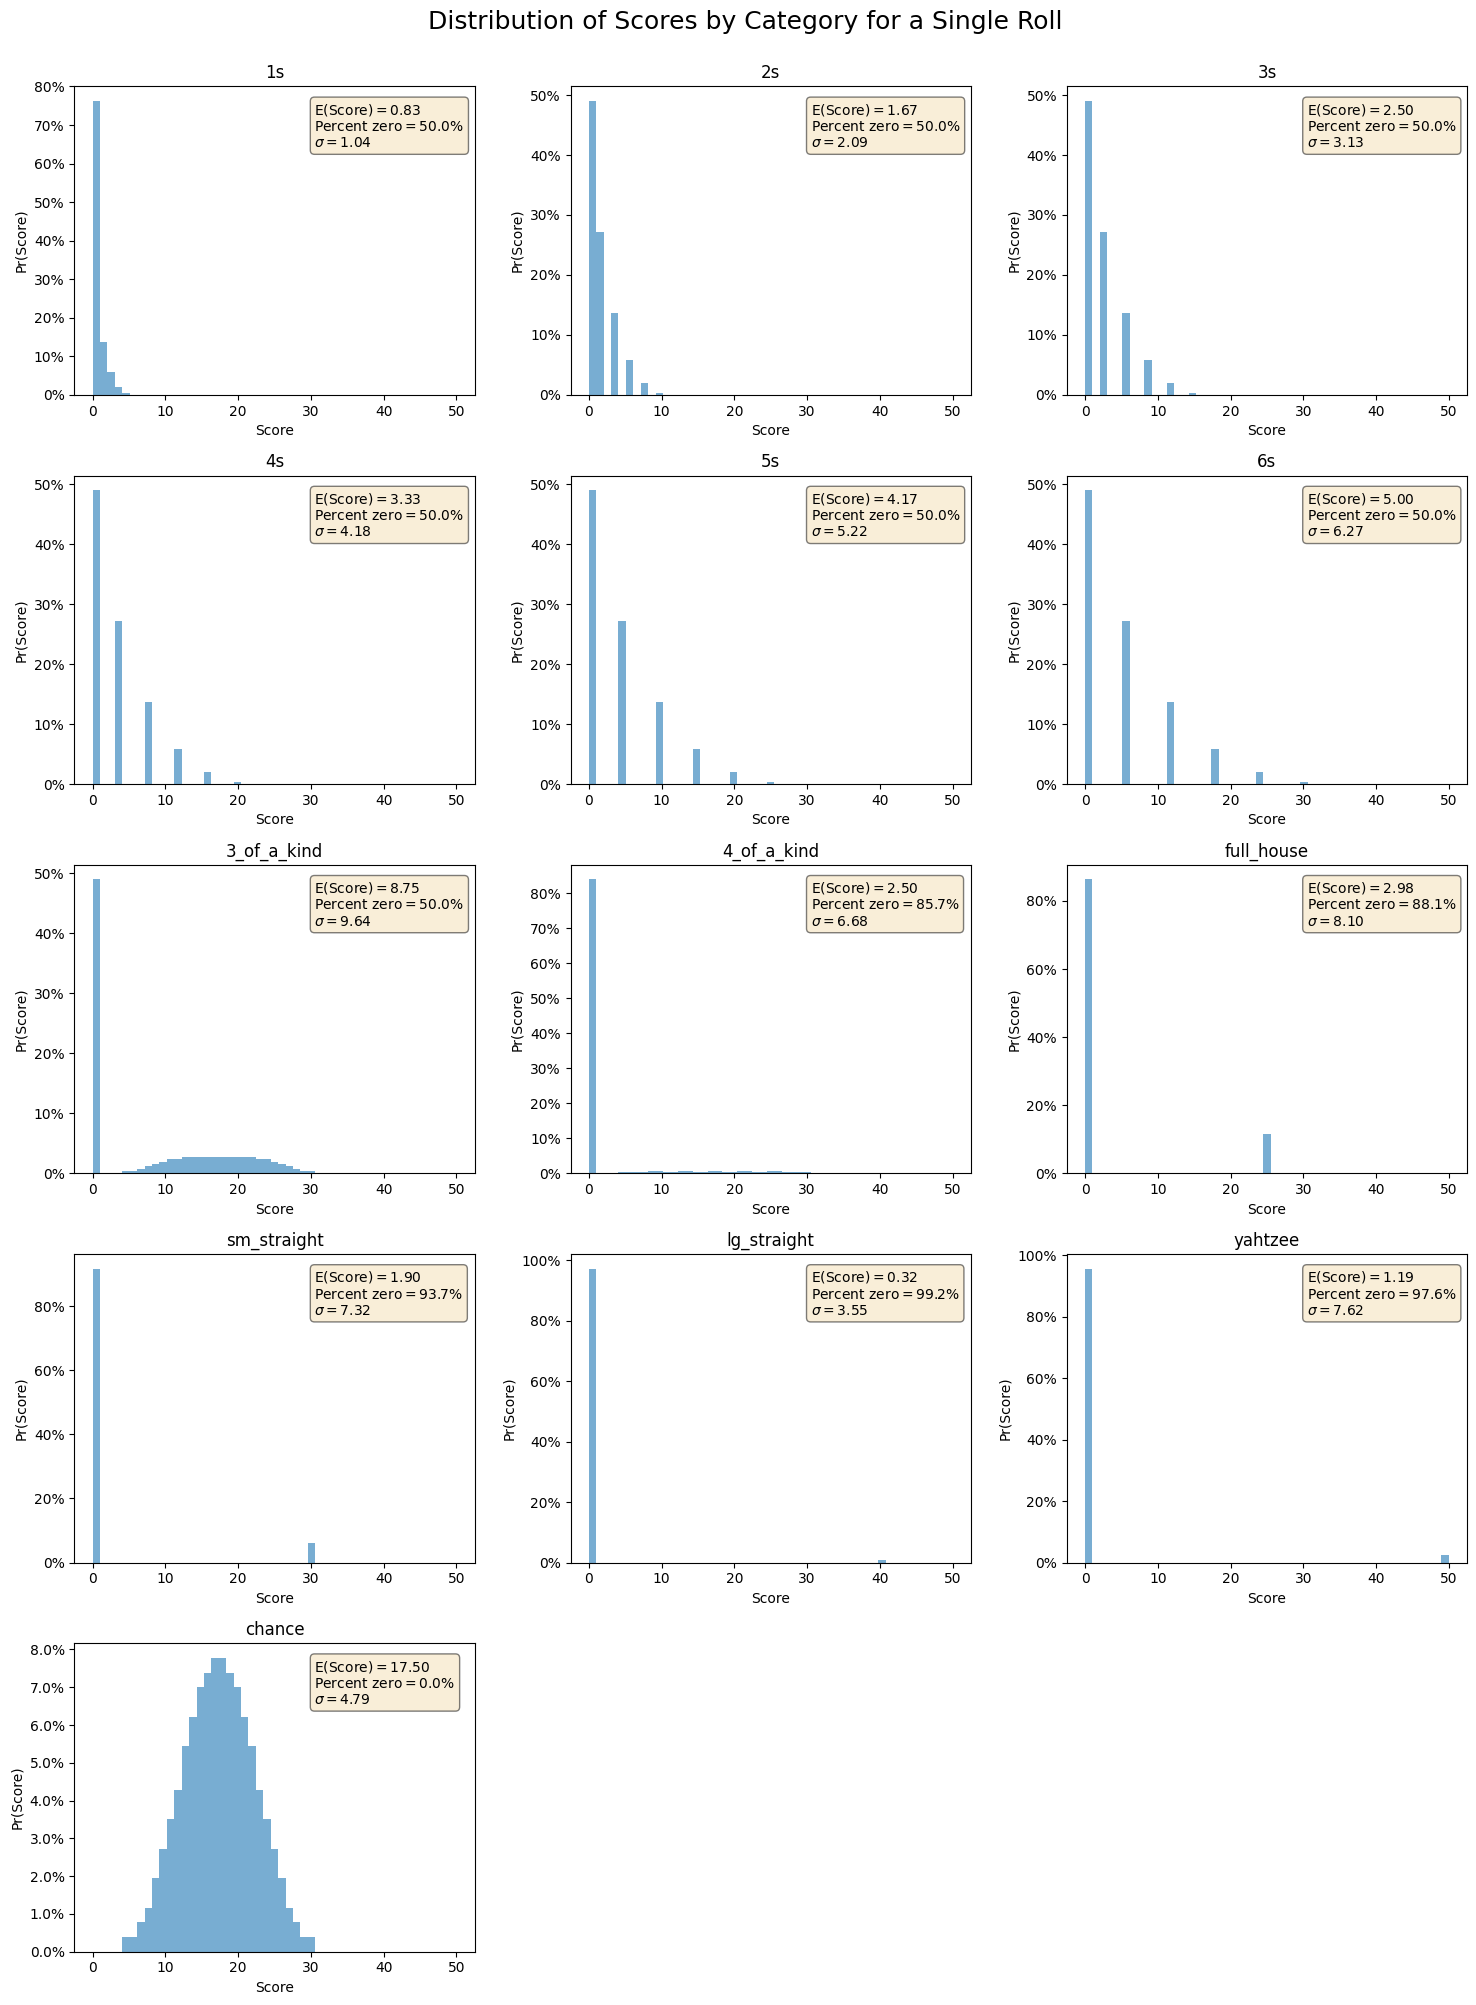

In [71]:
# Create histograms of potential score for each category
n_rows = 5
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
axes = axes.flatten()
for i, c in zip(range(0, 13), CATEGORIES):
    bins = np.linspace(0, 50)

    vals = all_rolls_scores[:,i]

    mu = vals.mean()
    sigma = vals.std()
    pct_zero = len(vals[vals==0])/len(vals) * 100
    textstr = '\n'.join((
        r'$\mathrm{E(Score)}=%.2f$' % (mu, ),
        r'$\mathrm{Percent\ zero}=%.1f\%%$' % (pct_zero, ),
        r'$\sigma=%.2f$' % (sigma, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axes[i].text(0.6, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
    verticalalignment='top', bbox=props)
    
    axes[i].hist(vals, bins=bins, alpha = 0.6, linewidth=5, density=True)
    axes[i].set_title(f'{c}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Pr(Score)')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Remove extra graphs
for i in range(len(CATEGORIES), len(axes)):
    fig.delaxes(axes[i])


plt.suptitle('Distribution of Scores by Category for a Single Roll', y=1, fontsize=18)
plt.tight_layout()

plt.savefig('figures/single_roll_category_scores.png')


# 1. Simple random strategy

## a. Purely random

In [77]:
game_states_purely_random = []

# Use different seed for each iteration
for i in tqdm(range(1, 50000, 5), miniters=10000/100):
    r = RandomStrategy(start_seed=i, rng_seed = int(math.pow(2, 32) - 1 - i), tiered_strategy=False)
    game_states_purely_random.append(r.run_strategy())

100%|██████████| 10000/10000 [00:23<00:00, 422.07it/s]


## b. Tiered strategy

In [78]:
game_states_tiered_random = []

# Use different seed for each iteration
for i in tqdm(range(1, 50000, 5), miniters=10000/100):
    r = RandomStrategy(start_seed=i, rng_seed = int(math.pow(2, 32) - 1 - i), tiered_strategy=True)
    game_states_tiered_random.append(r.run_strategy())

100%|██████████| 10000/10000 [00:24<00:00, 415.66it/s]


# 2. Simple greedy strategy
Prioritize expected score of next most imminent roll

## a. First greedy variant: Prioritize earning upper section bonus

In [79]:
game_states_greedy_upper = []

# Use different seed for each iteration
for i in tqdm(range(1, 50000, 5), miniters=10000/100):
    g = GreedyStrategy(start_seed=i, prioritize_upper_section=True)
    game_states_greedy_upper.append(g.run_strategy())

100%|██████████| 10000/10000 [17:27<00:00,  9.55it/s]


## b. Second greedy variant: Do not prioritize earning upper section bonus

In [80]:
game_states_greedy_no_upper = []

# Use different seed for each iteration
for i in tqdm(range(1, 50000, 5), miniters=10000/100):
    g = GreedyStrategy(start_seed=i, prioritize_upper_section=False)
    game_states_greedy_no_upper.append(g.run_strategy())

100%|██████████| 10000/10000 [17:06<00:00,  9.74it/s]


## c. Third greedy variant: New tie break order

In [ ]:
tie_break_order_new = [ 'yahtzee', '6s', '5s', '4s', '3s', '2s', '1s',
                                    'lg_straight', 
                                    'sm_straight', 
                                    'full_house',
                                    '4_of_a_kind', 
                                    '3_of_a_kind',
                                    'chance']

game_states_greedy_new_tie_break = []

# Use different seed for each iteration
for i in tqdm(range(1, 50000, 5), miniters=10000/100):
    g = GreedyStrategy(start_seed=i, prioritize_upper_section=True, tie_break_order=tie_break_order_new)
    game_states_greedy_new_tie_break.append(g.run_strategy())

  1%|          | 100/10000 [00:10<17:06,  9.64it/s]

# 3. Analyze results

In [85]:
# Save results locally
!pip install pyarrow -q
import pyarrow
for out, label in zip([game_states_purely_random, game_states_tiered_random, game_states_greedy_upper, game_states_greedy_no_upper],
                ['purely_random', 'tiered_random', 'greedy_upper', 'greedy_no_upper']):
    df = pd.DataFrame(out)
    df.drop(columns=['available_categories', 'potential_scores', 'rolls_remaining', 'dice_values'], inplace=True)

    df.to_csv(f'data/{label}_runs.csv.gzip', compression='gzip', sep=";")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
os.makedirs('data', exist_ok=True)

pd.read_csv(filename, compression='gzip' 

In [ ]:
from collections import defaultdict
# Split into scores and score order
round_scores = pd.DataFrame(df_upper['scores'].to_list(), columns = CATEGORIES)

order_round_to_category_dict = defaultdict(list)
order_category_to_round_dict = defaultdict(list)

# score order by col
for i, r in df_upper.iterrows():
    for j, v in enumerate(r['score_order']):
        # Standardize Yahtzee bonuses
        if 'yahtzee, ' in v:
            order_round_to_category_dict[j].append('yahtzee_bonus')
            order_category_to_round_dict['yahtzee_bonus'].append(j)
        else:
            order_round_to_category_dict[j].append(v)
            order_category_to_round_dict[v].append(j)

order_round_to_category_df = pd.DataFrame(order_round_to_category_dict)

In [ ]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(1, 13, num=13)
ax.hist(order_category_to_round_dict['chance'], bins=bins)

In [ ]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(0, df_upper['final_score'].max())
ax.hist(df_upper['final_score'], bins=bins)

In [ ]:
len(df_upper['score_order'].iloc[0])